# Stage 2 Analysis Notebook

Analyze stage 2 (sDSR) training: loss decay, recon/focal/sub decomposition, validation metrics, and visual diagnostics to understand why loss stays high (especially the subspace term) when following paper parameters.

In [8]:
# Setup and paths
import sys
from pathlib import Path

# Project root: run notebook from repo root, or from notebooks/ (then parent is root)
_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

import re
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Paths
CKPT_DIR = PROJECT_ROOT / "checkpoints"
MACHINE_TYPE = "fan"
STAGE1_CKPT = CKPT_DIR / "stage1" / MACHINE_TYPE / "stage1_fan_best.pt"
STAGE2_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_best.pt"
STAGE2_FINAL_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_final.pt"
# Optional: path to DCASE data (same as training) for validation/dataloader
DATA_PATH = "/mnt/ssd/LaCie/dcase2020-task2-dev-dataset"  # e.g. PROJECT_ROOT / ".." / "data" / "dcase2020-task2-dev-dataset"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
print(f"Stage1 checkpoint exists: {STAGE1_CKPT.exists()}")
print(f"Stage2 best checkpoint exists: {STAGE2_CKPT.exists()}")

Device: cuda
Stage1 checkpoint exists: True
Stage2 best checkpoint exists: True


## 1. Parse training log

Paste your training stdout below, or set `LOG_FILE` to a path (e.g. `train_stage2_fan.log`). Parsed arrays: `steps`, `loss_total`, `loss_recon`, `loss_focal`, `loss_sub`, `lr`.

In [3]:
# Training log: paste stdout here or set LOG_FILE
LOG_FILE = "../checkpoints/stage2/fan/train_stage2_fan.log"  # e.g. PROJECT_ROOT / "train_stage2_fan.log"
PASTED_LOG = """
[   100] loss=8.2549  recon=0.7530  focal=0.0768  sub=0.6483  lr=5.05e-05  (4.6 it/s)
[   200] loss=4.2165  recon=0.3612  focal=0.0338  sub=0.5706  lr=1.50e-04  (4.7 it/s)
[  1000] loss=2.9148  recon=0.2368  focal=0.0251  sub=0.5219  lr=1.97e-04  (4.7 it/s)
[ 10000] loss=2.2876  recon=0.1821  focal=0.0132  sub=0.4531  lr=1.02e-06  (4.7 it/s)
"""

def parse_stage2_log(log_text: str):
    pattern = re.compile(
        r"\[\s*(\d+)\].*?loss=([\d.]+)\s+recon=([\d.]+)\s+focal=([\d.]+)\s+sub=([\d.]+).*?lr=([\d.e+-]+)"
    )
    steps, loss_total, loss_recon, loss_focal, loss_sub, lr = [], [], [], [], [], []
    for m in pattern.finditer(log_text):
        steps.append(int(m.group(1)))
        loss_total.append(float(m.group(2)))
        loss_recon.append(float(m.group(3)))
        loss_focal.append(float(m.group(4)))
        loss_sub.append(float(m.group(5)))
        lr.append(float(m.group(6)))
    return (
        np.array(steps),
        np.array(loss_total),
        np.array(loss_recon),
        np.array(loss_focal),
        np.array(loss_sub),
        np.array(lr),
    )

if LOG_FILE and Path(LOG_FILE).exists():
    log_text = Path(LOG_FILE).read_text()
else:
    log_text = PASTED_LOG

steps, loss_total, loss_recon, loss_focal, loss_sub, lr = parse_stage2_log(log_text)
if len(steps) > 0:
    print(f"Parsed {len(steps)} log lines (steps: {steps.min()}-{steps.max()})")
else:
    print("Parsed 0 log lines.")
if len(steps) > 0:
    print(f"  total: {loss_total[-1]:.4f}, recon: {loss_recon[-1]:.4f}, focal: {loss_focal[-1]:.4f}, sub: {loss_sub[-1]:.4f}")

Parsed 100 log lines (steps: 100-10000)
  total: 2.2876, recon: 0.1821, focal: 0.0132, sub: 0.4531


## 2. Loss curves

- **Total loss vs step**: confirm slow decay and plateau.
- **Raw terms**: recon, focal, sub (sub often plateaus while recon keeps decreasing).
- **Weighted contributions**: `10*recon`, `1*focal`, `1*sub` to see which term dominates total.
- **Learning rate vs step**: warmup (first 200 iters) and cosine decay to 1e-6.

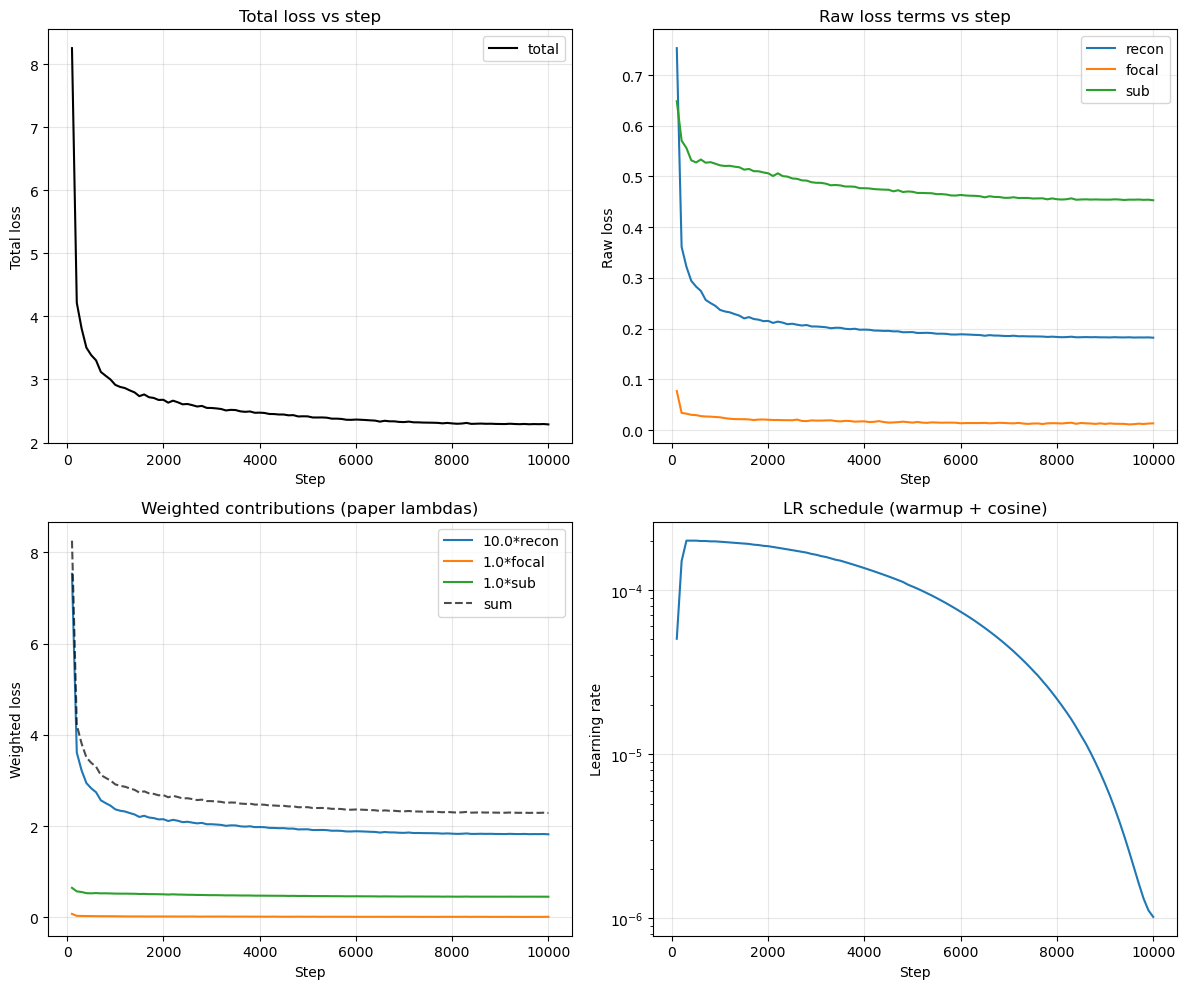

In [4]:
# Paper lambdas (same as stage2 trainer)
LAMBDA_RECON, LAMBDA_FOCAL, LAMBDA_SUB = 10.0, 1.0, 1.0

if len(steps) == 0:
    print("No parsed log data. Paste full log in PASTED_LOG or set LOG_FILE.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Total loss vs step
    ax = axes[0, 0]
    ax.plot(steps, loss_total, color="black", label="total")
    ax.set_xlabel("Step")
    ax.set_ylabel("Total loss")
    ax.set_title("Total loss vs step")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Raw terms vs step
    ax = axes[0, 1]
    ax.plot(steps, loss_recon, label="recon")
    ax.plot(steps, loss_focal, label="focal")
    ax.plot(steps, loss_sub, label="sub")
    ax.set_xlabel("Step")
    ax.set_ylabel("Raw loss")
    ax.set_title("Raw loss terms vs step")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Weighted contributions
    ax = axes[1, 0]
    w_recon = LAMBDA_RECON * loss_recon
    w_focal = LAMBDA_FOCAL * loss_focal
    w_sub = LAMBDA_SUB * loss_sub
    ax.plot(steps, w_recon, label=f"{LAMBDA_RECON}*recon")
    ax.plot(steps, w_focal, label=f"{LAMBDA_FOCAL}*focal")
    ax.plot(steps, w_sub, label=f"{LAMBDA_SUB}*sub")
    ax.plot(steps, w_recon + w_focal + w_sub, "k--", alpha=0.7, label="sum")
    ax.set_xlabel("Step")
    ax.set_ylabel("Weighted loss")
    ax.set_title("Weighted contributions (paper lambdas)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # LR vs step
    ax = axes[1, 1]
    ax.semilogy(steps, lr)
    ax.set_xlabel("Step")
    ax.set_ylabel("Learning rate")
    ax.set_title("LR schedule (warmup + cosine)")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 3. Load model and validation-style metrics

Load stage1 and stage2 checkpoints, then run N batches without gradients to compute average recon/focal/sub (and optional sub_top / sub_bot) with the same lambdas as training.

In [5]:
# Build model (same as scripts/train.py)
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer
from src.models.sDSR.s_dsr import sDSR, sDSRConfig
from src.models.sDSR.loss import FocalLoss

def build_vq_vae(n_mels: int, T: int):
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(4096, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

def build_s_dsr(vq_vae, n_mels: int, T: int):
    cfg = sDSRConfig(
        embedding_dim=128,
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        n_mels=n_mels,
        T=T,
    )
    return sDSR(vq_vae, cfg)

n_mels, T = 128, 320
if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset
    _ds = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _, _, n_mels, T = _ds.data.shape

vq_vae = build_vq_vae(n_mels, T)
ckpt_s1 = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=False)
vq_vae.load_state_dict(ckpt_s1["model_state_dict"])

model = build_s_dsr(vq_vae, n_mels, T)
ckpt_s2 = torch.load(STAGE2_CKPT, map_location="cpu", weights_only=False)
model.load_state_dict(ckpt_s2["model_state_dict"])
model = model.to(DEVICE)
model.eval()

focal_loss_fn = FocalLoss(gamma=2.0)
print("Model loaded.")

Model loaded.


In [9]:
# Validation loop: same losses as trainer (recon, focal, sub; optional sub_top / sub_bot)
from torch.utils.data import DataLoader

if DATA_PATH is None:
    print("Set DATA_PATH to run validation loop (e.g. path to DCASE root).")
else:
    from src.data.dataset import DCASE2020Task2LogMelDataset
    val_dataset = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=True)
    n_val_batches = min(100, len(val_loader))

    accum = {"total": 0.0, "recon": 0.0, "focal": 0.0, "sub": 0.0, "sub_top": 0.0, "sub_bot": 0.0}
    n_sub_top_bot = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= n_val_batches:
                break
            x = batch[0] if isinstance(batch, (list, tuple)) else batch
            x = x.to(DEVICE)
            out = model.forward_train(x)
            loss_recon = F.mse_loss(out["x"], out["x_s"]).item()
            loss_focal = focal_loss_fn(out["m_out"], out["M"]).item()
            if "recon_feat_bot" in out and "recon_feat_top" in out and "q_bot" in out and "q_top" in out:
                loss_sub_bot = F.mse_loss(out["recon_feat_bot"], out["q_bot"].detach()).item()
                loss_sub_top = F.mse_loss(out["recon_feat_top"], out["q_top"].detach()).item()
                loss_sub = loss_sub_bot + loss_sub_top
                accum["sub_top"] += loss_sub_top
                accum["sub_bot"] += loss_sub_bot
                n_sub_top_bot += 1
            else:
                loss_sub = 0.0
            total = LAMBDA_RECON * loss_recon + LAMBDA_FOCAL * loss_focal + LAMBDA_SUB * loss_sub
            accum["total"] += total
            accum["recon"] += loss_recon
            accum["focal"] += loss_focal
            accum["sub"] += loss_sub

    n = n_val_batches
    for k in ["total", "recon", "focal", "sub"]:
        accum[k] /= n
    if n_sub_top_bot:
        accum["sub_top"] /= n_sub_top_bot
        accum["sub_bot"] /= n_sub_top_bot
    print("Validation (no grad, same lambdas):")
    print(f"  total = {accum['total']:.4f}, recon = {accum['recon']:.4f}, focal = {accum['focal']:.4f}, sub = {accum['sub']:.4f}")
    if n_sub_top_bot:
        print(f"  sub_top = {accum['sub_top']:.4f}, sub_bot = {accum['sub_bot']:.4f}")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Validation (no grad, same lambdas):
  total = 2.3149, recon = 0.1839, focal = 0.0178, sub = 0.4576
  sub_top = 0.0253, sub_bot = 0.4324


## 4. Visual diagnostics

Plot input `x`, general recon `x_g`, object-specific recon `x_s`, difference `x_g - x_s`, GT mask `M`, and anomaly output `m_out` (e.g. softmax anomaly channel). Use one sample from a batch. Set DATA_PATH for real data; otherwise a random batch is used for layout only.

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM


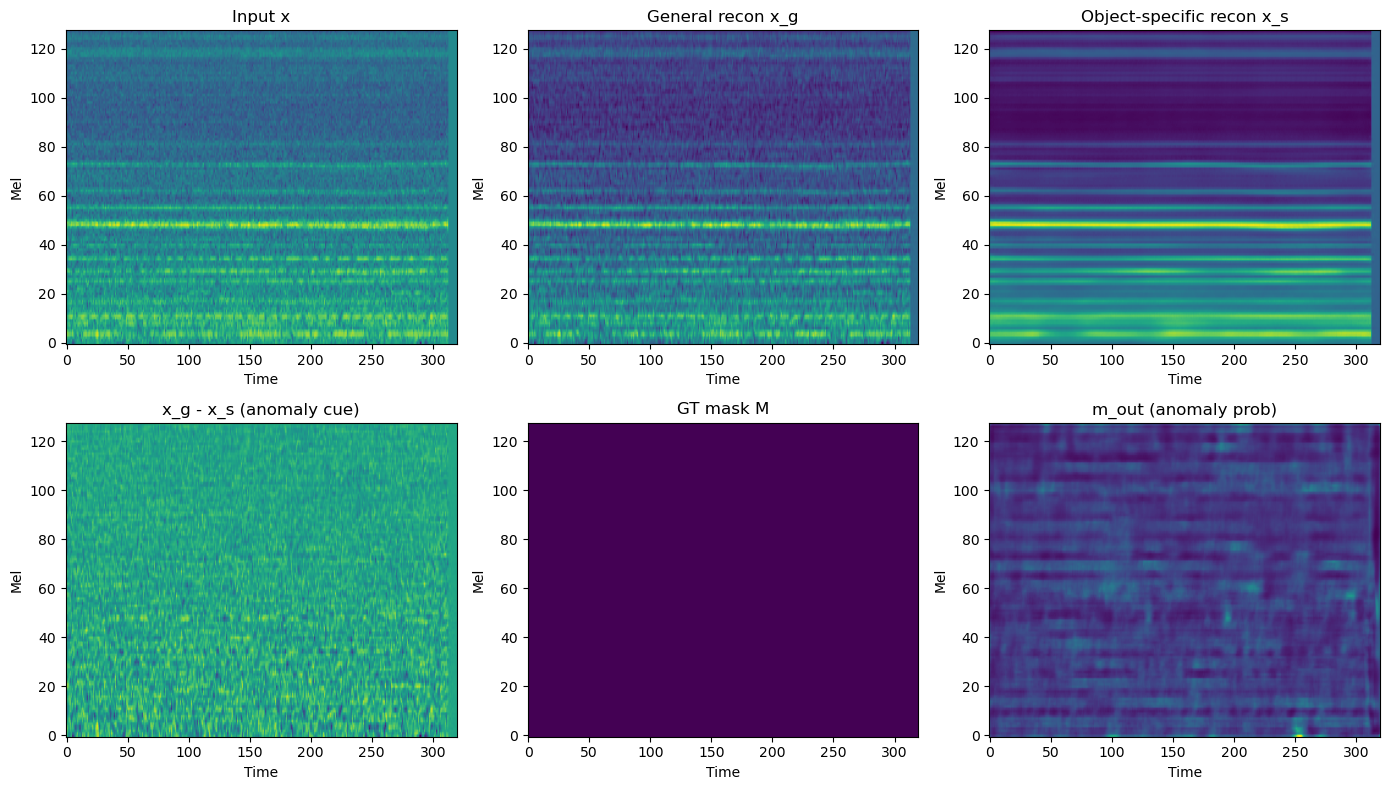

In [10]:
# Get one batch: from dataset if DATA_PATH set, else random
if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset
    from torch.utils.data import DataLoader
    _viz_ds = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _viz_loader = DataLoader(_viz_ds, batch_size=4, shuffle=True, num_workers=0)
    x_viz = next(iter(_viz_loader))[0].to(DEVICE)
else:
    x_viz = torch.randn(4, 1, n_mels, T, device=DEVICE)

with torch.no_grad():
    out_viz = model.forward_train(x_viz)

# Pick first sample
idx = 0
x_np = x_viz[idx, 0].cpu().numpy()
x_g_np = out_viz["x_g"][idx, 0].cpu().numpy()
x_s_np = out_viz["x_s"][idx, 0].cpu().numpy()
diff_np = (out_viz["x_g"] - out_viz["x_s"])[idx, 0].cpu().numpy()
M_np = out_viz["M"][idx, 0].cpu().numpy()
# m_out: (B, 2, H, W) logits -> anomaly prob
m_probs = F.softmax(out_viz["m_out"], dim=1)
m_anom_np = m_probs[idx, 1].cpu().numpy()  # anomaly channel

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0, 0].imshow(x_np, aspect="auto", origin="lower")
axes[0, 0].set_title("Input x")
axes[0, 1].imshow(x_g_np, aspect="auto", origin="lower")
axes[0, 1].set_title("General recon x_g")
axes[0, 2].imshow(x_s_np, aspect="auto", origin="lower")
axes[0, 2].set_title("Object-specific recon x_s")
axes[1, 0].imshow(diff_np, aspect="auto", origin="lower")
axes[1, 0].set_title("x_g - x_s (anomaly cue)")
axes[1, 1].imshow(M_np, aspect="auto", origin="lower")
axes[1, 1].set_title("GT mask M")
axes[1, 2].imshow(m_anom_np, aspect="auto", origin="lower")
axes[1, 2].set_title("m_out (anomaly prob)")
for ax in axes.flat:
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
plt.tight_layout()
plt.show()

## 5. Optional: gradient norms

Run a few training steps and record total grad norm (or per-layer) before `optimizer.step()`. If sub loss is high but gradients are tiny, consider higher lr or different initialization for subspace modules.

In [11]:
# Gradient norms over a few training steps (optional)
model.train()
trainable = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable, lr=2e-4)
focal_fn = FocalLoss(gamma=2.0)

if DATA_PATH is not None:
    from src.data.dataset import DCASE2020Task2LogMelDataset
    from torch.utils.data import DataLoader
    _grad_ds = DCASE2020Task2LogMelDataset(root=str(DATA_PATH), machine_type=MACHINE_TYPE, normalize=True)
    _grad_loader = DataLoader(_grad_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
    _grad_iter = iter(_grad_loader)
    grad_steps = min(20, len(_grad_loader))
else:
    _grad_iter = None
    grad_steps = 10

grad_norms = []
for step in range(grad_steps):
    if _grad_iter is not None:
        try:
            x_batch = next(_grad_iter)[0].to(DEVICE)
        except StopIteration:
            _grad_iter = iter(_grad_loader)
            x_batch = next(_grad_iter)[0].to(DEVICE)
    else:
        x_batch = torch.randn(16, 1, n_mels, T, device=DEVICE)
    optimizer.zero_grad(set_to_none=True)
    out = model.forward_train(x_batch)
    loss_recon = F.mse_loss(out["x"], out["x_s"])
    loss_focal = focal_fn(out["m_out"], out["M"])
    if "recon_feat_bot" in out and "q_bot" in out:
        loss_sub = F.mse_loss(out["recon_feat_bot"], out["q_bot"].detach()) + F.mse_loss(out["recon_feat_top"], out["q_top"].detach())
    else:
        loss_sub = torch.tensor(0.0, device=DEVICE)
    loss = LAMBDA_RECON * loss_recon + LAMBDA_FOCAL * loss_focal + LAMBDA_SUB * loss_sub
    loss.backward()
    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
    grad_norms.append(total_norm.item())
    optimizer.step()

plt.figure(figsize=(8, 3))
plt.plot(grad_norms)
plt.xlabel("Step")
plt.ylabel("Total grad norm")
plt.title("Gradient norm over training steps")
plt.grid(True, alpha=0.3)
plt.show()
model.eval()

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM


OutOfMemoryError: CUDA out of memory. Tried to allocate 160.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 15.62 MiB is free. Including non-PyTorch memory, this process has 3.66 GiB memory in use. Of the allocated memory 3.48 GiB is allocated by PyTorch, and 93.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 6. What to look for & paper parameters

### What to look for
- **Sub loss dominating and plateauing** → Subspace restriction is the bottleneck. Consider more iterations, different lr for subspace modules, or checking capacity of `SubspaceRestrictionModule`.
- **Recon high** → Object decoder reconstruction poor; check stage 1 quality first.
- **Focal high** → Anomaly detection head not matching M; check mask generation and alignment.

### Paper parameters (from code)
- `lambda_recon=10`, `lambda_focal=1`, `lambda_sub=1`
- `lr=2e-4`, warmup 200 iters, cosine decay to `lr_min=1e-6`
- Batch size 16, grad_clip 1.0
- FocalLoss `gamma=2.0`
- Total loss = 10*recon + 1*focal + 1*sub